## mmvids 结果转为 gtchunk idx 的形式

In [55]:
from tqdm import tqdm
import re

def hms_to_seconds(hms_str):
    """Converts an HH:MM:SS or HH-MM-SS string to total seconds."""
    parts = re.split(r'[-:]', hms_str)
    if len(parts) != 3:
        raise ValueError("Invalid time format. Expected HH:MM:SS or HH-MM-SS.")
    
    hours = int(parts[0])
    minutes = int(parts[1])
    seconds = int(parts[2])
    
    return hours * 3600 + minutes * 60 + seconds


def parse_clip_filename(filename):

    # 使用正则表达式匹配时间部分
    match = re.search(r'(\d{2}-\d{2}-\d{2})_to_(\d{2}-\d{2}-\d{2})\.mp4$', filename)

    if match:
        start_time_raw = match.group(1)
        end_time_raw = match.group(2)

        start_seconds = hms_to_seconds(start_time_raw)
        end_seconds = hms_to_seconds(end_time_raw)

        return [start_seconds, end_seconds]

    else:
        return None


import json

mmvid_videomme_medium = '/share/minghao/VideoProjects/lmm-eval/mmvidgts/demo.json'
mmvid_videomme_medium = '/share/minghao/VideoProjects/lmm-eval/mmvidgts/mlvu_test.json'

datas = []
with open(mmvid_videomme_medium, 'r') as file:
    datas = json.load(file)

print(len(datas))


record = {}
for data in tqdm(datas):
    if 'topk_clip_paths' not in data:
        continue
    video_name = data['video_name']
    question = data['question']
    unqiue_id = video_name + '.mp4' + '_' + question
    record[unqiue_id] = None
    all_time_spans = []
    for clip_name in data['topk_clip_paths']:
        time_spans = parse_clip_filename(clip_name)
        all_time_spans.append(time_spans)

    record[unqiue_id] = all_time_spans

print(f'size: {len(record)}')

with open('/share/minghao/VideoProjects/lmm-eval/mmvidgts/mlvu_test_clean.json', 'w') as f:
    json.dump(record, f, indent=4)

562


100%|██████████| 562/562 [00:00<00:00, 19939.76it/s]

size: 510


In [25]:

with open('/share/minghao/VideoProjects/lmm-eval/mmvidgts/videomme_mid_clean.json', 'r') as file:
    datas_1 = json.load(file)

with open('/share/minghao/VideoProjects/lmm-eval/mmvidgts/videomme_long_clean.json', 'r') as file:
    datas_2 = json.load(file)

datas_1.update(datas_2)
with open('/share/minghao/VideoProjects/lmm-eval/mmvidgts/videomme_mid_long_clean.json', 'w') as f:
    json.dump(datas_1, f, indent=4)

# 计算 cache reduction

In [ ]:
br1 = 1
tokens_per_chunk_br1 = 1440/br1
br2 = 4
tokens_per_chunk_br2 = 1440/br2
total_chunk = 26 # 26 13 6
high_chunk = 6 # 
low_chunk = 20
full_tokens = tokens_per_chunk_br1 * total_chunk

cache_reduction = 1 - (tokens_per_chunk_br1*high_chunk + tokens_per_chunk_br2*low_chunk)/full_tokens
print(f'cache_reduction: {cache_reduction}')

avg_tokens_num = (tokens_per_chunk_br1*high_chunk + tokens_per_chunk_br2*low_chunk)/(total_chunk*10)
print(f'avg_tokens_num: {avg_tokens_num}')

In [ ]:
rd = 72.6
ratio = (1 * 0.75 + 0.25 * rd/100)/1
print(f'{ratio*100:.1f}')

In [ ]:
speed_x1 = 233.1
speed_x2 = [139.7, 65.81, 56.3, 52.1, 51.4]
speed_x3 = [73.7, 55.2, 48.1, 42.9, 40.2]

for s in speed_x3:
    print(f'{speed_x1/s:.1f}')



---
# PostTraing



In [ ]:
import os
import re
import json

# 数据
result_dir = '/share/minghao/Projects/lmms-eval/mainexpres/Exp7/MLVU/cp5knextqa3k_allqkv_wobe_24x81632'
file_names = os.listdir(result_dir)

score_2_32_file_names = []
score_2_file_names = []
score_32_file_names = []

for name in file_names:
    if '_2_32' in name:
        score_2_32_file_names.append(name)
    elif '_2_' in name:
        score_2_file_names.append(name)
    elif '_32_' in name:
        score_32_file_names.append(name)

# 定义提取 ckpt 后面数字的函数
def extract_ckpt_number(item):
    match = re.search(r'ckpt(\d+)', item)  # 使用正则表达式提取 ckpt 后面的数字
    if match:
        return int(match.group(1))  # 返回数字并转换为整数
    return 0  # 如果没有找到，返回 0（或其他默认值）

# # 按照 ckpt 后面的数字排序
score_2_32_file_names = sorted(score_2_32_file_names, key=extract_ckpt_number)
score_2_file_names = sorted(score_2_file_names, key=extract_ckpt_number)
score_32_file_names = sorted(score_32_file_names, key=extract_ckpt_number)

def get_score(file_name):
    scores_dir = os.path.join(result_dir, file_name, 'shuyan__VideoXL_weight_8')
    # 读入目录下的jsonl文件
    json_files = [f for f in os.listdir(scores_dir) if f.endswith('.json')]
    json_file = json_files[-1]
    json_path = os.path.join(scores_dir, json_file)

    with open(json_path, 'r') as f:
        result = json.load(f)

    score = result['results']['mlvu']['mlvu_perception_score,none']
    return score

score_2_32 = [get_score(name) for name in score_2_32_file_names]
score_2 = [get_score(name) for name in score_2_file_names]
score_32 = [get_score(name) for name in score_32_file_names]

In [ ]:
import matplotlib.pyplot as plt
import os

# 数据
score_2_32_before = 64.55
score_2_before = 64.64
score_32_before = 62.67

score_2_32 = [score_2_32_before] + score_2_32
score_2 = [score_2_before] + score_2
score_32 = [score_32_before] + score_32
x1 = list(range(len(score_2_32)))  
x2 = list(range(len(score_2)))  
x3 = list(range(len(score_32)))  

# 绘制折线图
plt.plot(x1, score_2_32, label="ratio=mix@top3", marker='o', linestyle='-', color='#4C72B0')  # 蓝色
plt.plot(x2, score_2, label="ratio=2", marker='s', linestyle='--', color='#55A868')  # 绿色
plt.plot(x3, score_32, label="ratio=32", marker='^', linestyle='-.', color='#C44E52')  # 红色

# 绘制水平虚线
plt.axhline(y=score_2_before, color='g', linestyle=':', )  # 绿色虚线
plt.axhline(y=score_32_before, color='r', linestyle=':', )  # 红色虚线
plt.axhline(y=score_2_32_before, color='b', linestyle=':',)  # 蓝色虚线
plt.xticks([0, 1, 2, 3, 4], ['0k', '1k', '2k', '3k', '4k'])  # 设置刻度位置和标签

# 添加标题和标签
plt.title("MLVU Score")
plt.xlabel("Training Data")
plt.ylabel("Scores")
plt.grid(True)
# 显示图例
plt.legend()

# 显示图形
plt.show()


In [ ]:
def make_minor(list1, list2):
    new_list = []

    length = min(len(list1), len(list2))
    list1 = list1[:length]
    list2 = list2[:length]

    for a, b in zip(list1, list2):
        new_list.append(a - b)
    return new_list

list_1 = make_minor(score_2_32, score_2)
list_2 = make_minor(score_2_32, score_32)

score_2_32_before = 64.55
score_2_before = 64.64
score_32_before = 62.67

delta_mix_2 = score_2_32_before - score_2_before
delta_mix_32 = score_2_32_before - score_32_before

x1= list(range(len(list_1)))  # 假设 x 轴是 1, 2, 3, 4
x2= list(range(len(list_2)))

# 绘制折线图
plt.plot(x1, list_1, label="mix-x2", marker='o', linestyle='-', color='b')  # 蓝色
plt.plot(x2, list_2, label="mix-x32", marker='s', linestyle='--', color='g')  # 绿色

plt.axhline(y=delta_mix_2, color='b', linestyle=':', label="mix-2")  # 绿色虚线
plt.axhline(y=delta_mix_32, color='g', linestyle=':', label="mix-32")  # 红色虚线

# 添加标题和标签
plt.title("Score Comparison")
plt.xlabel("X Axis")
plt.ylabel("Scores")

# 显示图例
plt.legend()

# 显示图形
plt.show()

---

In [ ]:
import json

path1 = '/share/minghao/Projects/lmms-eval/mainexpres/Exp1/MLVU/videoxl_br32/shuyan__VideoXL_weight_8/20250104_173408_samples_mlvu.jsonl'
path2 = '/share/minghao/Projects/lmms-eval/mainexpres/Exp1/MLVU/videoxl_br32/shuyan__VideoXL_weight_8/20250104_092228_samples_mlvu.jsonl'
path3 = '/share/minghao/Projects/lmms-eval/mainexpres/Exp1/MLVU/videoxl_br32/shuyan__VideoXL_weight_8/20250103_003101_samples_mlvu.jsonl'

def load_json(path):
    datas = []
    with open(path, 'r') as file:
        for line in file:
            data = json.loads(line)
            datas.append(data)
    return datas

datas1 = load_json(path1)
datas2 = load_json(path2)
datas3 = load_json(path3)

datas = datas1 + datas2 + datas3
print(len(datas))

save_path = '/share/minghao/Projects/lmms-eval/mainexpres/Exp1/MLVU/videoxl_br32/shuyan__VideoXL_weight_8/all_samples_mlvu.jsonl'
with open(save_path, 'w') as file:
    for data in datas:
        line = json.dumps(data)
        file.write(line + '\n')


In [ ]:
accuracy_dict = {
    "AC": {
        "total": 206,
        "correct": 79,
        "accuracy": 38.349514563106794
    },
    "AO": {
        "total": 259,
        "correct": 161,
        "accuracy": 62.16216216216216
    },
    "ER": {
        "total": 352,
        "correct": 179,
        "accuracy": 50.85227272727273
    },
    "NQA": {
        "total": 355,
        "correct": 255,
        "accuracy": 71.83098591549296
    },
    "PQA": {
        "total": 539,
        "correct": 374,
        "accuracy": 69.38775510204081
    },
    "AR": {
        "total": 200,
        "correct": 105,
        "accuracy":
    },
    "TR": {
        "total": 264,
        "correct": 210,
        "accuracy": 79.54545454545455
    },
    "global": {
        "total": 2175,
        "correct": 1363,
        "accuracy": 62.67
    }
}

total = 0
correct = 0
for name, info in accuracy_dict.items():
    total = total + info['total']
    correct = correct + info['correct']

print(f'{total}')
print(f'{correct}')
print(f'{correct/total * 100:.2f}')


In [ ]:
# 平均压缩率 计算
ratio1 = 1/2
ratio2 = 1/32

total_chunk = 26
ratio1_chunk = 5
ratio2_chunk = total_chunk - ratio1_chunk

new_ratio = (ratio1_chunk * ratio1 + ratio2_chunk * ratio2)/total_chunk
new_ratio

# 研究一下plotqa

top1 和 top3 差异在哪？是什么决定了一个问题的对错

In [ ]:
import json

def get_ER_datas(path):
    with open(path, 'r') as file:
        datas = []
        for line in file:
            data = json.loads(line)
            if data['doc']['task_type'] == 'ER':
                datas.append(data)
        
    return datas

def get_PQA_datas(path):
    with open(path, 'r') as file:
        datas = []
        for line in file:
            data = json.loads(line)
            if data['doc']['task_type'] == 'PQA':
                datas.append(data)
        
    return datas

def get_datas(path, name='PQA'):
    with open(path, 'r') as file:
        datas = []
        for line in file:
            data = json.loads(line)
            if data['doc']['task_type'] == name:
                datas.append(data)
        
    return datas

def filter_error(datas):
    record_error_dict = {}
    for data in datas:
        mlvu_percetion_score = data['mlvu_perception_score'] 
        question_id = mlvu_percetion_score['question_id']
        pred_answer = mlvu_percetion_score['pred_answer']
        answer = mlvu_percetion_score['answer']
        if pred_answer != answer:
            
            pure_question = question_id.split('\nOptions:')[0].split('Question: ')[-1]
            unqiue_id = data['doc']['video_name'] + '_' + pure_question

            if unqiue_id in record_error_dict:
                print(f'need to dedup!')

            record_error_dict[unqiue_id] = {
                'pred_answer': pred_answer,
                'answer': answer
            }

    return record_error_dict

task_name = 'PQA'
top1_path = '/share/minghao/Projects/lmms-eval/results2/videoxl_adaptivebeacon_2_32_top1/shuyan__VideoXL_weight_8/20250115_145302_samples_mlvu.jsonl'
# top1_datas = get_PQA_datas(top1_path)
top1_datas = get_datas(top1_path, task_name)

top3_path = '/share/minghao/Projects/lmms-eval/results2/videoxl_adaptivebeacon_2_32_top3/shuyan__VideoXL_weight_8/20250115_114835_samples_mlvu.jsonl'
top4_path = '/share/minghao/Projects/lmms-eval/results2/videoxl_adaptivebeacon_2_32_top4/shuyan__VideoXL_weight_8/20250115_141359_samples_mlvu.jsonl'
# top3_datats = get_PQA_datas(top3_path)
top3_datats = get_datas(top4_path, task_name)

# assert len(top1_datas)==len(top3_datats)==539, len(top1_datas)

# 筛选出做错的那些
top1_errors = filter_error(top1_datas)
top3_errors = filter_error(top3_datats)

top1_errors_question_ids_set = set(list(top1_errors.keys()))
top3_errors_question_ids_set = set(list(top3_errors.keys()))

print(f'top1 error size: {len(top1_errors_question_ids_set)}')
print(f'top3 error size: {len(top3_errors_question_ids_set)}')

top1_f_top3_t = top1_errors_question_ids_set - top3_errors_question_ids_set
top1_t_top3_f = top3_errors_question_ids_set - top1_errors_question_ids_set

print(f'top1 ❌ top4 ✅: {len(top1_f_top3_t)}') 
print(f'top1 ✅ top4 ❌: {len(top1_t_top3_f)}') 
# for ele in top1_errors_question_ids_set - top3_errors_question_ids_set:
#     print(ele)

# 看一下他们的 gt 和 predict chunk idx

In [ ]:
# 载入 predict chunk json


predict_chunk_path = '/share/minghao/Projects/LanguageBind/llmseval/plotqa.json'
with open(predict_chunk_path, 'r') as f:
    predict_chunk = json.load(f)

# 载入 gt chunk json
gt_chunk_path = '/share/minghao/Projects/Video-XL/videoxl/videoxl/myeval/datas/searchgt/plotqa_w_gt_256.json'
with open(gt_chunk_path, 'r') as f:
    gt_chunk = json.load(f)

count = 0
print(f'top3 做对, top1做错')
for unique_id in top1_f_top3_t:
   
    if unique_id not in gt_chunk:
        print(unique_id)
        count = count + 1
        continue

    gt = gt_chunk[unique_id]
    predict_top1 = predict_chunk[unique_id]['top1']
    predict_top3 = predict_chunk[unique_id]['top3']
    gt = gt_chunk[unique_id]['gt_chunk_idx']
    print(f'gt: {gt}, top3: {predict_top3}, top1: {predict_top1}')

print('='*80)
print(f'top1 做对, top3做错')
for unique_id in top1_t_top3_f:
   
    if unique_id not in gt_chunk:
        # print(unique_id)
        count = count + 1
        continue

    gt = gt_chunk[unique_id]
    predict_top1 = predict_chunk[unique_id]['top1']
    predict_top3 = predict_chunk[unique_id]['top3']
    gt = gt_chunk[unique_id]['gt_chunk_idx']
    print(f'gt: {gt}, top1: {predict_top1}, top3: {predict_top3}')

In [ ]:
len(gt_chunk)

In [ ]:
path = '/share/minghao/Projects/lmms-eval/results/1128_1943_videoxl_videoxl_model_args_38784d/mlvu.json'

with open(path, 'r') as file:
    datas = json.load(file)
    
path = '/share/minghao/Projects/lmms-eval/results/1128_1943_videoxl_videoxl_model_args_38784d/samples_mlvu.jsonl'

with open(path, 'w') as file:
    for data in datas['logs']:
        line = json.dumps(data)
        file.write(line + '\n')


In [ ]:
import matplotlib.pyplot as plt

# 数据字典
datas_dict_1 = {0: 64.85, 25: 65.65, 50: 66.69, 70: 67.26, 100:68.70}

# 提取x和y值
x_values = list(datas_dict_1.keys())  # x轴数据
y_values_1 = list(datas_dict_1.values())  # 数据集1的y值

# 绘制折线图
plt.plot(x_values, y_values_1, label='w high density', marker='o', color='blue')
# 绘制基准线
plt.axhline(y=baseline_score, color='red', linestyle='--', label='VideoXL')

# 添加标题和标签
plt.title('Single Detail Task Score vs Hit Ratio')
plt.xlabel('Hit Ratio')
plt.ylabel('Avg Score')
plt.xticks(x_values)

# 显示图例
plt.legend()

# 展示图形
plt.show()






In [ ]:
import matplotlib.pyplot as plt

# 数据字典
datas_dict_1 = {4: 67.09, 8: 67.34, 16: 66.29, 32: 64.85}
datas_dict_2 = {4: 66.77, 8: 67.34, 16: 67.98, 32: 68.70}
baseline_score = 66.61

# 提取x和y值
x_values = list(datas_dict_1.keys())  # x轴数据
y_values_1 = list(datas_dict_1.values())  # 数据集1的y值
y_values_2 = list(datas_dict_2.values())  # 数据集2的y值

# 绘制折线图
plt.plot(x_values, y_values_1, label='wo high density', marker='o', color='blue')
plt.plot(x_values, y_values_2, label='w high density', marker='s', color='green')
# 绘制基准线
plt.axhline(y=baseline_score, color='red', linestyle='--', label='VideoXL')

# 添加标题和标签
plt.title('Single Detail Task Score vs Compression Ratio')
plt.xlabel('Compression Ration')
plt.ylabel('Avg Score')
plt.xticks(x_values)

# 显示图例
plt.legend()

# 展示图形
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# 数据字典
datas_dict_1 = {4: 67.09, 8: 67.34, 18: 66.29, 32: 64.85}
datas_dict_2 = {4: 66.77, 8: 67.34, 18: 67.98, 32: 68.70}

# 假设 baseline 模型的分数为 65
baseline_score = 65

# 提取x和y值
x_values = list(datas_dict_1.keys())  # x轴数据
y_values_1 = list(datas_dict_1.values())  # 数据集1的y值
y_values_2 = list(datas_dict_2.values())  # 数据集2的y值

# 绘制折线图
plt.plot(x_values, y_values_1, label='Data Set 1', marker='o', color='blue')
plt.plot(x_values, y_values_2, label='Data Set 2', marker='s', color='green')

# 绘制基准线
plt.axhline(y=baseline_score, color='red', linestyle='--', label='Baseline')

# 添加标题和标签
plt.title('Line Plot of Two Data Sets with Baseline')
plt.xlabel('X Axis')
plt.ylabel('Y Axis')

# 显示图例
plt.legend()

# 展示图形
plt.show()


# 画一些趋势图



In [ ]:
# 优化图形美观
plt.style.use('seaborn-poster')  # 使用美观的主题

# 创建绘图
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', linestyle='-', color='#ff7f0e', linewidth=2.5, label='Trend Line')

# 添加数据点的标签
for i in range(len(x)):
    plt.text(x[i], y[i] + 0.1, f'({x[i]}, {y[i]:.2f})', fontsize=12, ha='center', color='#1f77b4')

# 设置图表标题和轴标签
plt.title('Beautiful Trend of Data Points', fontsize=18, color='#2ca02c')
plt.xlabel('X-axis', fontsize=14, color='#9467bd')
plt.ylabel('Y-axis', fontsize=14, color='#9467bd')




In [ ]:
import matplotlib.pyplot as plt

# 数据字典
datas_dict = {2: 66.29, 4: 67.09, 8: 67.34}
plot_datas_dict = {2: 66.23, 4: 68.09, 8: 69,20} 
needle_datas_dict = {2: 75.77, 4: 75.77, 8: 74.37}
ego_datas_dict = {2: 56.82, 4: 56.82, 8: 57.39}

# 提取x和y数据
x = list(datas_dict.keys())
y = list(datas_dict.values())


# 优化图形美观
plt.style.use('ggplot')  # 使用美观的主题

# 创建绘图
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker='o', linestyle='-', color='#ff7f0e', linewidth=2.5, label='Trend Line')

# 添加数据点的标签
for i in range(len(x)):
    plt.text(x[i], y[i] + 0.1, f'({x[i]}, {y[i]:.2f})', fontsize=12, ha='center', color='#1f77b4')

# 图表标题和轴标签
plt.title('PlotQA-NeedleQA-Ego', fontsize=18, color='#2ca02c')
plt.xlabel('Compression Ratio', fontsize=14, color='#9467bd')
plt.ylabel('Avg Score', fontsize=14, color='#9467bd')

# 美化坐标轴
plt.xticks(fontsize=12, color='#8c564b')
plt.yticks(fontsize=12, color='#8c564b')
plt.grid(color='#d3d3d3', linestyle='--', linewidth=1.0)

# 添加图例
plt.legend(fontsize=12, loc='upper left')

# 显示图形
plt.show()



In [ ]:
import matplotlib.pyplot as plt

# 数据字典
datas_dict = {2: 66.29, 4: 67.09, 8: 67.34}
plot_datas_dict = {2: 66.23, 4: 68.09, 8: 69.20}
needle_datas_dict = {2: 75.77, 4: 75.77, 8: 74.37}
ego_datas_dict = {2: 56.82, 4: 56.82, 8: 57.39}

# 提取x和y数据
x = list(datas_dict.keys())

# 优化图形美观
plt.style.use('ggplot')  # 使用美观的主题

# 创建绘图
plt.figure(figsize=(10, 6))

# 绘制不同的曲线
plt.plot(x, list(datas_dict.values()), marker='o', linestyle='-', color='#ff7f0e', linewidth=2.5, label='Avg')
plt.plot(x, list(plot_datas_dict.values()), marker='s', linestyle='--', color='#1f77b4', linewidth=2.5, label='PlotQA')
plt.plot(x, list(needle_datas_dict.values()), marker='^', linestyle='-.', color='#2ca02c', linewidth=2.5, label='NeedleQA')
plt.plot(x, list(ego_datas_dict.values()), marker='d', linestyle=':', color='#9467bd', linewidth=2.5, label='EgoQA')

# 添加数据点的标签
for i in range(len(x)):
    plt.text(x[i], datas_dict[x[i]] + 0.1, f'({x[i]}, {datas_dict[x[i]]:.2f})', fontsize=12, ha='center', color='#ff7f0e')
    plt.text(x[i], plot_datas_dict[x[i]] + 0.1, f'({x[i]}, {plot_datas_dict[x[i]]:.2f})', fontsize=12, ha='center', color='#1f77b4')
    plt.text(x[i], needle_datas_dict[x[i]] + 0.1, f'({x[i]}, {needle_datas_dict[x[i]]:.2f})', fontsize=12, ha='center', color='#2ca02c')
    plt.text(x[i], ego_datas_dict[x[i]] + 0.1, f'({x[i]}, {ego_datas_dict[x[i]]:.2f})', fontsize=12, ha='center', color='#9467bd')

# 图表标题和轴标签
plt.title('PlotQA-NeedleQA-Ego', fontsize=18)
plt.xlabel('Compression Ratio', fontsize=14)
plt.ylabel('Avg Score', fontsize=14)

# 美化坐标轴
plt.xticks(fontsize=12, color='#8c564b')
plt.yticks(fontsize=12, color='#8c564b')
plt.grid(color='#d3d3d3', linestyle='--', linewidth=1.0)

# 添加图例
plt.legend(fontsize=12, loc='upper left')

# 显示图形
plt.show()


---
# 查看 做错的 needle 任务是什么分布（持续时间，clip持续时间，gt frame 数量）

In [ ]:
import json
import os

sample_num = 256
check_task_type = 'NQA'
data_name = 'needle'
video_dir = f'/share/junjie/code/videofactory/Evaluation_LVBench/LVBench_all/video/{data_name}'
path = '/share/minghao/Projects/lmms-eval/results2/videoxl_adaptivebeacon_2_32/shuyan__VideoXL_weight_8/20250102_163528_samples_mlvu.jsonl'

with open(path, 'r') as file:
    datas = [json.loads(line) for line in file]

def get_record_error(no_reload_datas):
    record_error = {}
    record_error_list = []
    record = 0
    for every_res in no_reload_datas:

        mlvu_percetion_score = every_res['mlvu_perception_score']
        task_type = mlvu_percetion_score['task_type']

        unique_id = every_res['doc']['video_name'] + every_res['input']
        
        if task_type != check_task_type:
            continue
        
        pred_answer = mlvu_percetion_score['pred_answer']
        answer = mlvu_percetion_score['answer']

        inp = every_res['doc']['question']
        
        if pred_answer != answer:
            record_error[unique_id] = {'gt': answer, 'pred': pred_answer, 'inp':inp}

    return record_error

errors = get_record_error(datas)

In [ ]:
import json
import os
from tqdm import tqdm
import decord
from decord import VideoReader, cpu
import numpy as np

datas_with_gtspan_path = '/share/minghao/Projects/Video-XL/videoxl/videoxl/myeval/datas/needle.jsonl'

video_meta_dict = {}

with open(datas_with_gtspan_path, 'r') as file:
    for line in file:
        data = json.loads(line)
        video = data['video']
        video_meta = data['video_meta']
        video_meta_dict[video] = video_meta


situration_1 = 0
situration_2 = 0
situration_3 = 0

all_keys = []
record_obervations = {}
for key, val in tqdm(errors.items()):
    video = key.split('\n')[0]
    all_keys.append(video)
    video_path = os.path.join(video_dir, video)
    # 获取 duration
    # 获取 256 采样下的 gt 数量

    # read video
    if video not in video_meta_dict:
        # print(f'{video} not in video_meta_dict')
        situration_1 = situration_1 + 1
        continue
    video_meta = video_meta_dict[video]
    video_start_sec = video_meta[0]['video_start_sec']
    video_end_sec = video_meta[0]['video_end_sec']

    vr = VideoReader(video_path, ctx=cpu(0))
    fps = vr.get_avg_fps()  # 获取视频帧率
    max_frames_num = sample_num
    total_frame_num = len(vr)
    duration = total_frame_num/fps
    uniform_sampled_frames = np.linspace(0, total_frame_num - 1, max_frames_num, dtype=int)
    frame_idx = uniform_sampled_frames.tolist()

    have_gt_flag = False
    gt_indices = []
    gt_frame_idx = []
    for indice, this_idx in enumerate(frame_idx):
        counter_time = this_idx / fps
        if counter_time >= video_start_sec and counter_time <= video_end_sec:
            have_gt_flag = True
            gt_indices.append(this_idx)
            gt_frame_idx.append(indice)

    record_obervations[video] = {'gt_frames':len(gt_frame_idx), 'duration':duration, 'clip_duration':video_end_sec-video_start_sec}

    if have_gt_flag:
        # print(f'{video} have gt')
        situration_2 = situration_2 + 1
    else:
        # print(f'{video} no gt')
        situration_3 = situration_3 + 1

print(f'situration_1: {situration_1}')
print(f'situration_2: {situration_2}')
print(f'situration_3: {situration_3}')

In [ ]:
record_obervations

In [ ]:
import matplotlib.pyplot as plt

data = record_obervations
# Extract values for histograms
gt_frames = [v['gt_frames'] for v in data.values()]
durations = [v['duration'] for v in data.values()]
clip_durations = [v['clip_duration'] for v in data.values()]

# Plot histograms
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Ground truth frames
axes[0].hist(gt_frames, bins=range(min(gt_frames), max(gt_frames) + 2), color='skyblue', edgecolor='black')
axes[0].set_title('Ground Truth Frames Distribution')
axes[0].set_xlabel('GT Frames')
axes[0].set_ylabel('Frequency')

# Durations
axes[1].hist(durations, bins=7, color='lightgreen', edgecolor='black')
axes[1].set_title('Video Duration Distribution')
axes[1].set_xlabel('Duration (s)')

# Clip durations
axes[2].hist(clip_durations, bins=7, color='salmon', edgecolor='black')
axes[2].set_title('Clip Duration Distribution')
axes[2].set_xlabel('Clip Duration (s)')

plt.tight_layout()
plt.show()

# 预测 case 分析

In [ ]:
import json

check_task_type = 'NQA'

no_reload_result_path = '/share/minghao/Projects/lmms-eval/results/cp5knextqa3k_reload06_noreload/shuyan__VideoXL_weight_8/20241230_091641_samples_mlvu.jsonl'
reload_result_path = '/share/minghao/Projects/lmms-eval/results/cp5knextqa3k_reload/shuyan__VideoXL_weight_8/20241230_161910_samples_mlvu.jsonl'

with open(no_reload_result_path, 'r') as file:
    no_reload_datas = [json.loads(line) for line in file]

with open(reload_result_path, 'r') as file:
    reload_datas = [json.loads(line) for line in file]


def get_record_error(no_reload_datas):
    record_error = {}
    record_error_list = []
    record = 0
    for every_res in no_reload_datas:

        mlvu_percetion_score = every_res['mlvu_perception_score']
        task_type = mlvu_percetion_score['task_type']

        unique_id = every_res['doc']['video_name'] + every_res['input']
        
        if task_type != check_task_type:
            continue
        
        pred_answer = mlvu_percetion_score['pred_answer']
        answer = mlvu_percetion_score['answer']

        inp = every_res['doc']['question']
        
        if pred_answer != answer:
            record_error[unique_id] = {'gt': answer, 'pred': pred_answer, 'inp':inp}

    return record_error

no_reload_error = get_record_error(no_reload_datas)
reload_error = get_record_error(reload_datas)


diff_keys = set(reload_error.keys()) - set(no_reload_error.keys())
print(len(diff_keys))
print(f'is subset: {set(reload_error.keys()) <= set(no_reload_error.keys())}')
print(f'reload_error num: {len(set(reload_error.keys()))}')
print(f'no_reload_error num: {len(set(no_reload_error.keys()))}')
print(f'intersaction: {len(set(reload_error.keys()) & set(no_reload_error.keys()))}')


In [ ]:
# reload 之后仍然做错的
still_error = set(reload_error.keys()) & set(no_reload_error.keys())
print(f'still_error num: {len(still_error)}')
# 本来是错的 reload 之后做对的
correct_after_reload = set(no_reload_error.keys()) - set(reload_error.keys())
print(f'correct_after_reload num: {len(correct_after_reload)}')
# 本来是对的 reload 之后做错的
error_after_reload = set(reload_error.keys()) - set(no_reload_error.keys())
print(f'error_after_reload num: {len(error_after_reload)}')

In [ ]:
# tmp = correct_after_reload
# tmp = error_after_reload
tmp = still_error

# correct_after_reload_data_dict_list = []
# error_after_reload_data_dict_list = []
still_error_data_dict_list = []

for unique_id in tmp:
    
    pos = unique_id.find('\n')
    video = unique_id[:pos]
    inp = reload_error[unique_id]['inp']
    answer = reload_error[unique_id]['gt']
    lmms_eval_pred = reload_error[unique_id]['pred']

    still_error_data_dict_list.append(
        {
            'video': video,
            'inp': inp,
            'answer': answer,
            'lmms_eval_pred': lmms_eval_pred,
        }
    )

save_path = f'/share/minghao/Projects/Video-XL/videoxl/videoxl/myeval/datas/badcase/still_error_data_dict_list.jsonl'

import json

with open(save_path, 'w') as file:
    for data in still_error_data_dict_list:
        line = json.dumps(data)
        file.write(line + '\n')


# MLVU

## 为每个数据集获得分

In [10]:
import json
import os

result = '/share/minghao/VideoProjects/lmm-eval-sparse/logs/MLVUTest/videoxl-stage4-mlvu-test/0502_0831_videoxl_videoxl_model_args_43d856/mlvu_test.json'

prefix = result.split('/')[-1].split('_samples')[0]

if 'jsonl' in result:
    with open(result, 'r') as file:
        datas = [json.loads(line) for line in file]
else:
    with open(result, 'r') as file:
        datas = json.load(file)
        datas = datas['logs']

logs = datas

global_correct = 0
total = 0

correct_by_task = {}
total_by_task = {}

records_pred_answer = []
for every_res in logs:
    if 'mlvu_percetion_score' in every_res:
        mlvu_percetion_score = every_res['mlvu_percetion_score']
    elif 'mlvu_perception_score' in every_res:
        mlvu_percetion_score = every_res['mlvu_perception_score']
    task_type = mlvu_percetion_score['task_type']
    
    pred_answer = mlvu_percetion_score['pred_answer']

    answer = mlvu_percetion_score['answer']

    if pred_answer == answer:
        if task_type not in correct_by_task:
            correct_by_task[task_type] = 1
        else:
            correct_by_task[task_type] += 1

    if task_type not in total_by_task:
        total_by_task[task_type] = 1
    else:
        total_by_task[task_type] += 1

    if answer == pred_answer:
        global_correct += 1

    total = total + 1
new_result_to_result = {'holistic':{}, 'single':{}, 'multi':{}}

holistic = ['TR','AR','anomaly_reco','topic_reasoning']
single = ['NQA','PQA', "ER", 'needle','ego','plotQA']
multi = ['AC','AO','count','order']


for items in correct_by_task.items():
    task_type = items[0]
    correct = items[1]
    accuracy = correct_by_task[task_type]/total_by_task[task_type]*100
    print(f'{task_type} {correct_by_task[task_type]} {total_by_task[task_type]} {accuracy:.2f}')

    if task_type in holistic:
        category = 'holistic'
    elif task_type in single:
        category = 'single'
    elif task_type in multi:
        category = 'multi'

    if 'total' not in new_result_to_result[category]:
        new_result_to_result[category]['total'] = total_by_task[task_type]
        new_result_to_result[category]['correct'] = correct
    else:
        new_result_to_result[category]['total'] += total_by_task[task_type]
        new_result_to_result[category]['correct'] += correct

    new_result_to_result[task_type] = {
        'total': total_by_task[task_type],
        'correct': correct,
        'accuracy': accuracy
    }    

for category in ['holistic', 'single', 'multi']:
    this_correct = new_result_to_result[category]['correct']
    this_total = new_result_to_result[category]['total']
    accuracy = this_correct/this_total * 100
    new_result_to_result[category]['accuracy'] = accuracy
    print(f'{category} {correct} {total} {accuracy:.2f}')

print(f'global_correct: {global_correct}')
print(f'total: {total}')
print(f'ACC: {global_correct/total*100:.2f}')

new_result_to_result['global'] = {
    'total': total,
    'correct': global_correct,
    'accuracy': global_correct/total*100
}

task_types = list(new_result_to_result.keys())
save_name = prefix + '_' + 'results_each_dataset'
for tt in task_types:
    if tt == 'global':
        continue
    save_name = save_name + '_' + tt
save_name = save_name + '.json'

save_dir = os.path.dirname(result)
save_path = os.path.join(save_dir, save_name)

with open(save_path, 'w') as file:
    json.dump(new_result_to_result, file, indent=4)

anomaly_reco 18 39 46.15
sportsQA 17 36 47.22
order 40 70 57.14
needleQA 33 60 55.00
plotQA 33 50 66.00
topic_reasoning 63 91 69.23
ego 31 53 58.49
tutorialQA 12 43 27.91
count 22 60 36.67
holistic 22 502 59.04
single 22 502 52.05
multi 22 502 50.00
global_correct: 269
total: 502
ACC: 53.59


In [11]:
(36.67 + 27.91 + 58.49 + 69.23 + 66.00 + 55.00 + 57.14 + 47.22 + 46.15)/9

51.53444444444444

----
## 获得最优解，打印markdown形式

In [1]:
import json

results_each_dataset = []

results_each_dataset = None
if results_each_dataset is None:
    import glob
    directory = "/share/minghao/VideoProjects/lmm-eval-sparse/logs/MLVU"
    # 递归搜索所有子目录，匹配包含 'qin' 的 .jsonl 文件
    results_each_dataset = glob.glob(f"{directory}/**/*results_each_dataset*.json", recursive=True)

# results_each_dataset = [tmp for tmp in results_each_dataset if "notrain" not in tmp]
results_each_dataset = [tmp for tmp in results_each_dataset if "stage4" not in tmp]

columns = ['topic_reasoning', 'anomaly_reco', 'needle', 'plotQA', 'ego', 'count', 'order', 'global']
# columns = ['topic_reasoning', 'anomaly_reco', 'needleQA', 'plotQA', 'ego', 'count', 'order', 'global', 'sportsQA', 'tutorialQA']


markdown_table = "| Model Name | " + " | ".join(columns) + " |\n"
markdown_table += "|" + "------------|" + "-------|" * len(columns) + "\n"

max_performance_record = {}
for result_path in results_each_dataset:
    # print(result_path)
    with open(result_path, 'r') as f:
        data = json.load(f)

    model_name = result_path.split('/')[-3]
    # 提取列名和准确率
    accuracies = []
    for col in columns:
        accuracies.extend([f"{data[col]['accuracy']:.2f}" ])
        if (col not in max_performance_record or data[col]['accuracy'] > max_performance_record[col]['accuracy']) and col != 'global':
            max_performance_record[col] = data[col]
            max_performance_record[col]['source'] = model_name

    # 构造 Markdown 表格
    markdown_table += f"|  {model_name}  | " + " | ".join(accuracies) + " |\n"

# 打印结果
print(markdown_table)
print()
# print(max_performance_record)
print()

correct = 0
total = 0

avg_acc = 0

for key, val in max_performance_record.items():
    print(f"{key}: correct {val['correct']}, total {val['total']}, acc {val['accuracy']:.2f}, source {val['source']}")
    correct = correct + val['correct']
    total = total + val['total']
    avg_acc = avg_acc + val['accuracy']

print(f"\nBest Performance: {correct / total*100:.2f}")
print(f"Avg Acc: {avg_acc / len(max_performance_record):.2f}")

| Model Name | topic_reasoning | anomaly_reco | needle | plotQA | ego | count | order | global |
|------------|-------|-------|-------|-------|-------|-------|-------|-------|
|  mlvu-sparse-256-b4_p3_top8_c4_cmpr4  | 81.75 | 71.00 | 85.07 | 78.48 | 68.18 | 44.66 | 77.61 | 74.29 |
|  mlvu-sparse-256-b4_p3_top1_c4_cmpr4  | 76.05 | 68.00 | 84.51 | 72.54 | 66.76 | 44.66 | 63.32 | 69.83 |
|  mlvu-sparse-256-b4_p3_top4_c4_cmpr4  | 81.37 | 69.00 | 84.51 | 77.18 | 68.18 | 45.63 | 72.59 | 73.14 |
|  mlvu-sparse-256-b4_p3_top7_c4_cmpr4  | 81.75 | 71.00 | 85.07 | 78.66 | 67.90 | 43.69 | 78.38 | 74.29 |
|  mlvu-sparse-256-b4_p3_top6_c4_cmpr4  | 81.37 | 69.50 | 84.79 | 79.04 | 68.18 | 44.17 | 77.61 | 74.15 |
|  mlvu-sparse-256-b4_p3_top2_c4_cmpr4  | 79.47 | 68.00 | 84.23 | 75.32 | 67.61 | 45.63 | 67.57 | 71.62 |
|  mlvu-sparse-256-b4_p3_top3_c4_cmpr4  | 80.23 | 68.00 | 84.79 | 75.51 | 68.18 | 45.15 | 70.66 | 72.26 |
|  mlvu-sparse-256-b4_p3_top5_c4_cmpr4  | 81.37 | 68.50 | 85.07 | 77.37 | 68.18 | 

In [4]:
# DEV
rec = {'topic_reasoning':(216, 263),'anomaly_reco':(148, 200),'needle':(302, 355),'plotQA':(426, 539),'ego':(240, 352),'count':(94, 206),'order':(203, 259) }

# TEST
# rec = {'topic_reasoning':(63, 91),'anomaly_reco':(18, 39),'needle':(38, 60),'plotQA':(32, 50),'ego':(34, 53),'count':(20, 60),'order':(37, 70),'sportsQA':(16, 36) ,'tutorialQA':(13, 43)}

total = 0
correct = 0
for key,(c, t) in rec.items():
    total = total + t
    correct = correct + c
print(f'acc: {correct/total*100:.2f}')

acc: 74.93


---
# Videomme

## 为每个数据集获得分数

In [3]:
# 获取各个长度下各个任务的分数

import json
import os

result = '/share/minghao/VideoProjects/lmm-eval-sparse/logs/VideoMME/videomme_mid-sparse-400-b4_p3_top5_c12_cmpr4/0524_1843_videoxl_videoxl_model_args_1a77cd/videomme_mid.json'
# result = '/share/LXRlxr0_0/code/videoxl2/lmm-eval/logs/Sparse5/videomme-bsz32/0515_1340_videoxl_videoxl_model_args_79c069/videomme_mid.json'

prefix = result.split('/')[-1].split('_samples')[0]

if 'jsonl' in result:
    with open(result, 'r') as file:
        datas = [json.loads(line) for line in file]
else:
    with open(result, 'r') as file:
        datas = json.load(file)

    datas = datas['logs']

logs = datas

global_correct = 0
total = 0

correct_by_duration = {}
correct_by_task = {}
total_by_duration = {}
total_by_task = {}

records_pred_answer = []
for every_res in logs:
    if 'videomme_percetion_score' in every_res:
        mlvu_percetion_score = every_res['videomme_percetion_score'] # 
    else:
        mlvu_percetion_score = every_res['videomme_perception_score']
    duration = mlvu_percetion_score['duration']
    task_type = mlvu_percetion_score['task_category']
    
    pred_answer = mlvu_percetion_score['pred_answer']
    answer = mlvu_percetion_score['answer']

    # pred_answer = every_res['filtered_resps'][0]
    # if len(pred_answer) > 5:
    #     records_pred_answer.append(pred_answer)
    #     continue

    if pred_answer == answer:
        if task_type not in correct_by_task:
            correct_by_task[task_type] = 1
        else:
            correct_by_task[task_type] += 1

        if duration not in correct_by_duration:
            correct_by_duration[duration] = 1
        else:
            correct_by_duration[duration] += 1

    if task_type not in total_by_task:
        total_by_task[task_type] = 1
    else:
        total_by_task[task_type] += 1

    if duration not in total_by_duration:
        total_by_duration[duration] = 1
    else:
        total_by_duration[duration] += 1

    if answer == pred_answer:
        global_correct += 1

    total = total + 1

new_result_to_result = {}

for items in correct_by_duration.items():
    duration = items[0]
    correct = items[1]
    accuracy = correct_by_duration[duration]/total_by_duration[duration]*100
    print(f'{duration} {correct_by_duration[duration]} {total_by_duration[duration]} {accuracy:.2f}')

    new_result_to_result[duration] = {
        'total': total_by_duration[duration],
        'correct': correct,
        'accuracy': accuracy
    }

for items in correct_by_task.items():
    task_type = items[0]
    correct = items[1]
    accuracy = correct_by_task[task_type]/total_by_task[task_type]*100
    print(f'{task_type} {correct_by_task[task_type]} {total_by_task[task_type]} {accuracy:.2f}')

    new_result_to_result[task_type] = {
        'total': total_by_task[task_type],
        'correct': correct,
        'accuracy': accuracy
    }

print(f'global_correct: {global_correct}')
print(f'total: {total}')
print(f'ACC: {global_correct/total*100:.2f}')

new_result_to_result['global'] = {
    'total': total,
    'correct': global_correct,
    'accuracy': global_correct/total*100
}

task_types = list(new_result_to_result.keys())
save_name = prefix + '_' + 'results_each_dataset'
for tt in task_types:
    if ' ' in tt:
        index = tt.find(' ')
        tt = tt[0] + tt[index+1]
    if tt == 'global':
        continue
    save_name = save_name + '_' + str(tt)
save_name = save_name + '.json'

save_dir = os.path.dirname(result)
save_path = os.path.join(save_dir, save_name)
save_path
with open(save_path, 'w') as file:
    json.dump(new_result_to_result, file, indent=4)

medium 557 900 61.89
Object Recognition 90 132 68.18
Object Reasoning 89 134 66.42
OCR Problems 39 68 57.35
Temporal Reasoning 37 73 50.68
Attribute Perception 46 73 63.01
Action Recognition 75 119 63.03
Counting Problem 36 95 37.89
Spatial Reasoning 14 18 77.78
Action Reasoning 33 58 56.90
Spatial Perception 10 21 47.62
Information Synopsis 66 78 84.62
Temporal Perception 22 31 70.97
global_correct: 557
total: 900
ACC: 61.89


## 打印 markdown 形式

In [54]:
import json

results_each_dataset = [
    '/share/minghao/Projects/lmms-eval/mainexpres/Exp7_2/cp5knextqa3k_allqkv/videomme/videomme_2_32_top1_wbe/shuyan__VideoXL_weight_8/20250306_144757_results_each_dataset_short_medium_long_OR_TR_AP_OP_TP_OR_AR_IS_SR_AR_CP_SP.json',
    '/share/minghao/Projects/lmms-eval/mainexpres/Exp7_2/cp5knextqa3k_allqkv/videomme/videomme_2_32_top2_wbe/shuyan__VideoXL_weight_8/20250306_133324_results_each_dataset_short_medium_long_OR_TR_AP_OP_TP_OR_AR_IS_SR_AR_CP_SP.json',
    '/share/minghao/Projects/lmms-eval/mainexpres/Exp7_2/cp5knextqa3k_allqkv/videomme/videomme_2_32_top5_wbe/shuyan__VideoXL_weight_8/20250306_103657_results_each_dataset_short_medium_long_OR_TR_AP_OP_TP_OR_AR_IS_SR_AR_CP_SP.json',
    '/share/minghao/Projects/lmms-eval/mainexpres/Exp7_2/cp5knextqa3k_allqkv/videomme/videomme_2_32_top4_wbe/shuyan__VideoXL_weight_8/20250306_121911_results_each_dataset_short_medium_long_OR_TR_AP_OP_TP_OR_AR_IS_SR_AR_CP_SP.json',
    '/share/minghao/Projects/lmms-eval/mainexpres/Exp7_2/cp5knextqa3k_allqkv/videomme/videomme_2_32_top3_wbe/shuyan__VideoXL_weight_8/20250306_103627_results_each_dataset_short_medium_long_OR_TR_AP_OP_TP_OR_AR_IS_SR_AR_CP_SP.json'
]


results_each_dataset = None
if results_each_dataset is None:
    import glob
    directory = "/share/minghao/VideoProjects/lmm-eval-sparse/logs/VideoMME"
    # 递归搜索所有子目录，匹配包含 'qin' 的 .jsonl 文件
    results_each_dataset = glob.glob(f"{directory}/**/*results_each_dataset*.json", recursive=True)

results_each_dataset = [tmp for tmp in results_each_dataset if 'stage4_sparse' not in tmp]

columns = ['short', 'medium', 'long', 'global']
# columns = ['medium', 'long']
columns = [
 'Counting Problem',
 'Object Reasoning',
 'Temporal Reasoning',
 'Attribute Perception',
 'OCR Problems',
 'Temporal Perception',
 'Object Recognition',
 'Action Reasoning',
 'Information Synopsis',
 'Spatial Reasoning',
 'Action Recognition',
 'Spatial Perception',
 'global']

markdown_table = "| Model Name | " + " | ".join(columns) + " |\n"
markdown_table += "|" + "------------|" + "-------|" * len(columns) + "\n"

max_performance_record = {}
for result_path in results_each_dataset:
    # print(result_path)
    with open(result_path, 'r') as f:
        data = json.load(f)

    model_name = result_path.split('/')[-3]
    # 提取列名和准确率
    accuracies = []
    for col in columns:
        accuracies.extend([f"{data[col]['accuracy']:.2f}" ])
        if (col not in max_performance_record or data[col]['accuracy'] > max_performance_record[col]['accuracy']) and col != 'global':
            max_performance_record[col] = data[col]
            max_performance_record[col]['source'] = model_name
            
    # 构造 Markdown 表格
    markdown_table += f"|  {model_name}  | " + " | ".join(accuracies) + " |\n"

# 打印结果
print(markdown_table)
print()

correct = 0
total = 0
for key, val in max_performance_record.items():
    if key == 'global':
        continue
    print(f"{key}: correct {val['correct']}, total {val['total']}, acc {val['accuracy']:.2f}, source {val['source']}")
    correct = correct + val['correct']
    total = total + val['total']

print(f"\nBest Performance: {correct / total*100:.2f}")

| Model Name | Counting Problem | Object Reasoning | Temporal Reasoning | Attribute Perception | OCR Problems | Temporal Perception | Object Recognition | Action Reasoning | Information Synopsis | Spatial Reasoning | Action Recognition | Spatial Perception | global |
|------------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|
|  videomme-sparse-400-b4_p3_top2_c6_cmpr4  | 40.30 | 60.35 | 48.59 | 72.07 | 64.75 | 74.55 | 63.56 | 57.89 | 81.11 | 76.79 | 68.37 | 61.11 | 63.00 |
|  videomme-sparse-400-b4_p3_top4_c6_cmpr4  | 45.15 | 60.13 | 49.15 | 74.32 | 68.35 | 74.55 | 64.41 | 59.65 | 80.80 | 78.57 | 70.29 | 61.11 | 64.37 |
|  videomme-sparse-400-b4_p3_top3_c6_cmpr4  | 42.91 | 60.35 | 48.02 | 72.97 | 65.47 | 74.55 | 63.56 | 58.25 | 81.11 | 78.57 | 69.33 | 62.96 | 63.56 |
|  videomme-sparse-400-b4_p3_top5_c6_cmpr4  | 45.90 | 60.79 | 50.85 | 73.87 | 66.91 | 76.36 | 67.80 | 59.65 | 81.42 | 80.36 | 70.29 | 62.96 | 65.19 |
|  videomme_m

## 调整每个长度下的任务得分

In [5]:
# 获取各个长度下各个任务的分数

import json
import os


def work(result, specified_duration='medium'):

    prefix = result.split('/')[-1].split('_samples')[0]

    if 'jsonl' in result:
        with open(result, 'r') as file:
            datas = [json.loads(line) for line in file]
    else:
        with open(result, 'r') as file:
            datas = json.load(file)['logs']

    logs = datas

    global_correct = 0
    total = 0

    correct_by_duration = {}
    correct_by_task = {}
    total_by_duration = {}
    total_by_task = {}

    for every_res in logs:
        mlvu_percetion_score = every_res['videomme_percetion_score']
        duration = mlvu_percetion_score['duration']
        if duration != specified_duration:
            continue

        task_type = mlvu_percetion_score['task_category']
        
        pred_answer = mlvu_percetion_score['pred_answer']
        answer = mlvu_percetion_score['answer']

        if pred_answer == answer:
            if task_type not in correct_by_task:
                correct_by_task[task_type] = 1
            else:
                correct_by_task[task_type] += 1

            if duration not in correct_by_duration:
                correct_by_duration[duration] = 1
            else:
                correct_by_duration[duration] += 1

        if task_type not in total_by_task:
            total_by_task[task_type] = 1
        else:
            total_by_task[task_type] += 1

        if duration not in total_by_duration:
            total_by_duration[duration] = 1
        else:
            total_by_duration[duration] += 1

        if answer == pred_answer:
            global_correct += 1

        total = total + 1

        new_result_to_result = {}

    if len(correct_by_duration) == 0:
        return {}

    for items in correct_by_duration.items():
        duration = items[0]
        correct = items[1]
        accuracy = correct_by_duration[duration]/total_by_duration[duration]*100
        # print(f'{duration} {correct_by_duration[duration]} {total_by_duration[duration]} {accuracy:.2f}')

        new_result_to_result[duration] = {
            'total': total_by_duration[duration],
            'correct': correct,
            'accuracy': accuracy
        }

    for items in correct_by_task.items():
        task_type = items[0]
        correct = items[1]
        accuracy = correct_by_task[task_type]/total_by_task[task_type]*100

        # print(f'{task_type} {correct_by_task[task_type]} {total_by_task[task_type]} {accuracy:.2f}')
        new_result_to_result[task_type] = {
            'total': total_by_task[task_type],
            'correct': correct,
            'accuracy': accuracy
        }

    # print(f'global_correct: {global_correct}')
    # print(f'total: {total}')
    # print(f'ACC: {global_correct/total*100:.2f}')

    new_result_to_result['global'] = {
        'total': total,
        'correct': global_correct,
        'accuracy': global_correct/total*100
    }

    return new_result_to_result
    

# results = [
#     '/share/minghao/VideoProjects/lmm-eval-sparse/logs/VideoMME/videomme-sparse-400-b4_p3_top1_c6_cmpr4/0524_0225_videoxl_videoxl_model_args_351fea/videomme.json',
#     '/share/minghao/VideoProjects/lmm-eval-sparse/logs/VideoMME/videomme-sparse-400-b4_p3_top2_c6_cmpr4/0524_0419_videoxl_videoxl_model_args_b50391/videomme.json',
#     '/share/minghao/VideoProjects/lmm-eval-sparse/logs/VideoMME/videomme-sparse-400-b4_p3_top3_c6_cmpr4/0524_0612_videoxl_videoxl_model_args_240515/videomme.json',
#     '/share/minghao/VideoProjects/lmm-eval-sparse/logs/VideoMME/videomme-sparse-400-b4_p3_top4_c6_cmpr4/0524_0807_videoxl_videoxl_model_args_5556e3/videomme.json',
#     '/share/minghao/VideoProjects/lmm-eval-sparse/logs/VideoMME/videomme-sparse-400-b4_p3_top5_c6_cmpr4/0524_1000_videoxl_videoxl_model_args_fe82fa/videomme.json'
#     ]

results = None
if results is None:
    import glob
    directory = "/share/minghao/VideoProjects/lmm-eval-sparse/logs/VideoMME_sub"
    # 递归搜索所有子目录，匹配包含 'qin' 的 .jsonl 文件
    results = glob.glob(f"{directory}/**/*videomme.json", recursive=True)


# results = [tmp for tmp in results if 'c12' in tmp]
results = [tmp for tmp in results if 'stage4' not in tmp]
# results = [tmp for tmp in results if 'mmvid' not in tmp]

specified_duration = 'short'

all_datas = {}
for result_path in results:
    model_name = result_path.split('/')[-3]
    result_dict = work(result_path, specified_duration=specified_duration)
    if len(result_dict) == 0:
        continue
    all_datas[model_name] = result_dict


# columns = ['short', 'medium', 'long', 'global']
# columns = ['medium']
columns = [
 'Counting Problem',
 'Object Reasoning',
 'Temporal Reasoning',
 'Attribute Perception',
 'OCR Problems',
 'Temporal Perception',
 'Object Recognition',
 'Action Reasoning',
 'Information Synopsis',
 'Spatial Reasoning',
 'Action Recognition',
 'Spatial Perception',
 'global']


new_columns = []
for tmp in columns:
    if ' ' in tmp:
        tmp = tmp.split(' ')
        new_name = tmp[0][0] + tmp[1][0]
        new_columns.append(new_name)
    else:
        new_columns.append(tmp)

markdown_table = "| Model Name | " + " | ".join(new_columns) + " |\n"
markdown_table += "|" + "------------|" + "-------|" * len(new_columns) + "\n"

max_performance_record = {}
for model_name, data in all_datas.items():
    # 提取列名和准确率
    accuracies = []
    for col in columns:
        if col not in data:
            continue
        accuracies.extend([f"{data[col]['accuracy']:.2f}" ])
        if (col not in max_performance_record or data[col]['accuracy'] > max_performance_record[col]['accuracy']) and col != 'global':
            max_performance_record[col] = data[col]
            max_performance_record[col]['source'] = model_name

    # 构造 Markdown 表格
    markdown_table += f"|  {model_name}  | " + " | ".join(accuracies) + " |\n"

# 打印结果
print(markdown_table)
print()
# print(max_performance_record)

correct = 0
total = 0

perception_tasks = [
    'Action Recognition',
    'Object Recognition',
    'Attribute Perception',
    'Spatial Perception',
    'Temporal Perception',
]

reasoning_tasks = [
    'Spatial Reasoning',
    'Temporal Reasoning',
    'Action Reasoning',
    'Object Reasoning',
]

other_tasks = [
    'Information Synopsis',
    'Counting Problem',
    'OCR Problems',
]

print(f'Perception Tasks !!!!')
for task in perception_tasks:
    if task not in max_performance_record:
        continue
    print(f"{task}: correct {max_performance_record[task]['correct']}, total {max_performance_record[task]['total']}, acc {max_performance_record[task]['accuracy']:.2f}, source {max_performance_record[task]['source']}")
    correct = correct + max_performance_record[task]['correct']
    total = total + max_performance_record[task]['total']

print(f'\nReasoning Tasks !!!!')
for task in reasoning_tasks:
    if task not in max_performance_record:
        continue
    print(f"{task}: correct {max_performance_record[task]['correct']}, total {max_performance_record[task]['total']}, acc {max_performance_record[task]['accuracy']:.2f}, source {max_performance_record[task]['source']}")
    correct = correct + max_performance_record[task]['correct']
    total = total + max_performance_record[task]['total']

print(f'\nOther Tasks !!!!')
for task in other_tasks:
    if task not in max_performance_record:
        continue
    print(f"{task}: correct {max_performance_record[task]['correct']}, total {max_performance_record[task]['total']}, acc {max_performance_record[task]['accuracy']:.2f}, source {max_performance_record[task]['source']}")
    correct = correct + max_performance_record[task]['correct']
    total = total + max_performance_record[task]['total']

# for key, val in max_performance_record.items():
#     if key == 'global':
#         continue
#     print(f"{key}: correct {val['correct']}, total {val['total']}, acc {val['accuracy']:.2f}, source {val['source']}")
#     correct = correct + val['correct']
#     total = total + val['total']

print(f"\nBest Performance: {correct / total*100:.2f}")



| Model Name | CP | OR | TR | AP | OP | TP | OR | AR | IS | SR | AR | SP | global |
|------------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|
|  videomme_w_subtitle-sparse-400-b4_p3_top5_c12_cmpr4  | 48.00 | 77.50 | 61.54 | 82.79 | 91.23 | 88.89 | 76.19 | 76.60 | 91.46 | 88.89 | 80.92 | 80.00 | 76.89 |
|  videomme_w_subtitle-sparse-400-b4_p3_top4_c12_cmpr4  | 48.00 | 77.50 | 61.54 | 82.79 | 91.23 | 88.89 | 76.19 | 76.60 | 91.46 | 88.89 | 80.15 | 80.00 | 76.78 |
|  videomme_w_subtitle-sparse-400-b4_p3_top7_c12_cmpr4  | 47.20 | 77.50 | 61.54 | 85.25 | 91.23 | 88.89 | 75.60 | 76.60 | 90.24 | 88.89 | 83.21 | 80.00 | 77.22 |
|  videomme_w_subtitle-sparse-400-b4_p3_top6_c12_cmpr4  | 48.00 | 77.50 | 69.23 | 84.43 | 91.23 | 88.89 | 75.00 | 76.60 | 90.24 | 88.89 | 81.68 | 80.00 | 77.00 |


Perception Tasks !!!!
Action Recognition: correct 109, total 131, acc 83.21, source videomme_w_subtitle-sparse-400-b4_p3_top7_c12_cmpr4
Object Reco

In [6]:
(68.22 + 61.65 + 77.67)/3

69.18

In [ ]:
Information Synopsis: correct 71, total 82, acc 86.59, source videomme-sparse-400-b4_p3_top2_c6_cmpr4


Action Recognition: correct 105, total 131, acc 80.15, source videomme_short-sparse-400-b4_p3_top6_c12_cmpr4
Spatial Perception: correct 24, total 30, acc 80.00, source videomme-sparse-400-b4_p3_top3_c6_cmpr4
Temporal Perception: correct 17, total 18, acc 94.44, source videomme_short-sparse-400-b4_p3_top6_c12_cmpr4
Object Recognition: correct 127, total 168, acc 75.60, source videomme_short-sparse-400-b4_p3_top6_c12_cmpr4
Attribute Perception: correct 102, total 122, acc 83.61, source videomme_short-sparse-400-b4_p3_top7_c12_cmpr4

Spatial Reasoning: correct 23, total 27, acc 88.89, source videomme-sparse-400-b4_p3_top5_c6_cmpr4
Object Reasoning: correct 60, total 80, acc 75.00, source videomme_short-sparse-400-b4_p3_top8_c12_cmpr4
Temporal Reasoning: correct 8, total 13, acc 61.54, source videomme_short-sparse-400-b4_p3_top6_c12_cmpr4
Action Reasoning: correct 35, total 47, acc 74.47, source videomme_short-sparse-400-b4_p3_top6_c12_cmpr4


Counting Problem: correct 68, total 125, acc 54.40, source videomme-sparse-400-b4_p3_top5_c6_cmpr4
OCR Problems: correct 49, total 57, acc 85.96, source videomme_short-sparse-400-b4_p3_top8_c12_cmpr4

In [40]:
(71 + 23 + 105 + 24 + 17 + 127 + 102 + 60 + 49 + 68 + 35 + 8)/900

0.7655555555555555

In [41]:
(64.9 + 58.8 + 76.6)/3

66.76666666666667

In [ ]:
best videomme-long
Information Synopsis: 127, 163

Perception
Action Recognition: 40, 63, c6_cmpr4
Object Recognition  24, 54  c6_cmpr4 
Temporal Perception 3, 6, c6_cmpr4
Attribute Perception: 16,27 c6_cmpr4

Reasoning
Spatial Reasoning 6, 11, c12_cmpr4
Action Reasoning, 103, 180, c12_cmpr4
Temporal Reasoning 49 91 c12_cmpr4
Object Reasoning  134, 240 c12_cmpr4_mmvid

其它：
OCR Problems: 8, 14, c6_cmpr4
Counting Problem: 19, 48, c12_cmpr4



In [21]:
total = 900
correct = 127 + 40 + 24 + 3 + 16 + 6 + 103 + 49 + 134 + 8 + 19
correct/total*100 # 64.9

58.77777777777777

In [ ]:
best videomme-mid
Information Synopsis: 66, 78

Perception
Spatial Perception: 11, 21 .b4_p3_c6_cmpr4_mmvid
Action Recognition: 76, 119, b4_p3_c4_cmpr8
Object Recognition  93, 132  c6_cmpr4_mmvid
Temporal Perception 24, 31, c6_cmpr4_mmvid
Attribute Perception: 51,73 c6_cmpr4

Reasoning
Spatial Reasoning 14, 18, c12_cmpr4
Action Reasoning, 33, 58, c6c12_cmpr4
Temporal Reasoning 45 73 c12_cmpr4_mmvid
Object Reasoning  92, 134 c12_cmpr4_mmvid

其它：
OCR Problems: 40, 68, c12_cmpr4_mmvid
Counting Problem：39, 95, c12_cmpr4

total = 900
correct = 66 + 11 + 76 + 93 + 24 + 51 + 14 + 33 + 45 + 92 + 40 + 39
correct/total*100 # 64.9

## 结果比较

In [ ]:
path1 = '/share/minghao/Projects/lmms-eval/results3/videoxl_videomme/shuyan__VideoXL_weight_8/20250115_200416_results_each_dataset_short_medium_long.json'
path2 = '/share/minghao/Projects/lmms-eval/results2/videoxl_adaptivebeacon_2_32_top5_videomme/shuyan__VideoXL_weight_8/20250116_005741_results_each_dataset_short_medium_long.json'
path2 = '/share/minghao/Projects/lmms-eval/results2/videoxl_adaptivebeacon_2_32_top3_videomme/shuyan__VideoXL_weight_8/20250116_004725_results_each_dataset_short_medium_long.json'

def load_json(path):
    with open(path, 'r') as f:
        datas = json.load(f)
    return datas


datas1 = load_json(path1)
datas2 = load_json(path2)

result = []
result.append("| Task | data1 | data2 | relation |")
result.append("|------|-------|-------|-------|")

for key1, value1 in datas1.items():
    if key1 == 'global':
        continue
    if key1 != 'long':
        continue
    if key1 in datas2:
        value2 = datas2[key1]
        for key11, value11 in value1.items():
            if key11 in value2:
                value22 = value2[key11]
                acc1 = value11['accuracy']
                acc2 = value22['accuracy']
                acc1 = round(acc1, 2)
                acc2 = round(acc2, 2)

                if acc1 > acc2:
                    relation = '>'
                elif acc1 == acc2:
                    relation = '='
                else:
                    relation = '<'
                # Append a row in Markdown format
                result.append(f"| {key1}-{key11} | {acc1} | {acc2} | {relation} |")

# Print the Markdown table
print("\n".join(result))


--- 
# VNBench

## 获取各个任务的得分

In [ ]:
import json
import os

result = '/share/minghao/Projects/lmms-eval/mainexpres/Exp7_2/videomme/videomme_2_32_top4_wbe/shuyan__VideoXL_weight_8/20250303_005024_samples_videomme.jsonl'

prefix = result.split('/')[-1].split('_samples')[0]

if 'jsonl' in result:
    with open(result, 'r') as file:
        datas = [json.loads(line) for line in file]
else:
    with open(result, 'r') as file:
        datas = json.load(file)

logs = datas

logs_by_video_id = {}
for every_res in logs:
    vnbench_perception_score = every_res['vnbench_perception_score']
    video_id = vnbench_perception_score['video_pure_name']
    if video_id not in logs_by_video_id:
        logs_by_video_id[video_id] = {
            "correct": 1 if vnbench_perception_score['answer'] == vnbench_perception_score['pred_answer'] else 0,
            "task_type": vnbench_perception_score['task_type']
        }
    else:
        if vnbench_perception_score['pred_answer'] == vnbench_perception_score['answer']:
            logs_by_video_id[video_id]['correct'] += 1


global_correct = 0
total = 0

correct_by_task = {}
total_by_task = {}
for video_id, info in logs_by_video_id.items():

    task_type = info['task_type']
    correct_count = info['correct']

    if correct_count == 4:
        if task_type not in correct_by_task:
            correct_by_task[task_type] = 1
        else:
            correct_by_task[task_type] += 1

        global_correct += 1

    if task_type not in total_by_task:
        total_by_task[task_type] = 1
    else:
        total_by_task[task_type] += 1

    total = total + 1

new_result_to_result = {}

for items in correct_by_task.items():
    task_type = items[0]
    correct = items[1]
    accuracy = correct_by_task[task_type]/total_by_task[task_type]*100
    print(f'{task_type} {correct_by_task[task_type]} {total_by_task[task_type]} {accuracy:.2f}')

    new_result_to_result[task_type] = {
        'total': total_by_task[task_type],
        'correct': correct,
        'accuracy': accuracy
    }

print(f'global_correct: {global_correct}')
print(f'total: {total}')
print(f'ACC: {global_correct/total*100:.2f}')

new_result_to_result['global'] = {
    'total': total,
    'correct': global_correct,
    'accuracy': global_correct/total*100
}

task_types = list(new_result_to_result.keys())
save_name = prefix + '_' + 'results_each_dataset'
for tt in task_types:
    if tt == 'global':
        continue
    save_name = save_name + '_' + tt
save_name = save_name + '.json'

save_dir = os.path.dirname(result)
save_path = os.path.join(save_dir, save_name)

with open(save_path, 'w') as file:
    json.dump(new_result_to_result, file, indent=4)

## 打印 markdown 表格

In [ ]:
import json

results_each_dataset = [
    '/share/minghao/Projects/lmms-eval/mainexpres/Exp1/vnbench/vnbench_2_32_top1/shuyan__VideoXL_weight_8/20250212_122354_results_each_dataset_ret_insert1_ret_edit1_ord_edit1_ord_insert2_cnt_edit1_cnt_edit2_cnt_insert1_ret_insert2_ord_insert1.json',
    '/share/minghao/Projects/lmms-eval/mainexpres/Exp1/vnbench/vnbench_2_32_top2/shuyan__VideoXL_weight_8/20250212_131007_results_each_dataset_ret_insert1_ret_edit1_ord_edit1_ord_insert2_cnt_edit1_cnt_edit2_cnt_insert1_ret_insert2_ord_insert1.json',
    '/share/minghao/Projects/lmms-eval/mainexpres/Exp1/vnbench/vnbench_2_32_top3/shuyan__VideoXL_weight_8/20250212_135735_results_each_dataset_ret_insert1_ret_edit1_ord_edit1_ord_insert2_cnt_edit1_cnt_edit2_cnt_insert1_ret_insert2_ord_insert1.json',
    '/share/minghao/Projects/lmms-eval/mainexpres/Exp1/vnbench/vnbench_2_32_top4/shuyan__VideoXL_weight_8/20250212_140359_results_each_dataset_ret_insert1_ret_edit1_ord_edit1_ord_insert2_cnt_edit1_cnt_edit2_cnt_insert1_ret_insert2_ord_insert1.json',
    '/share/minghao/Projects/lmms-eval/mainexpres/Exp1/vnbench/vnbench_2_32_top5/shuyan__VideoXL_weight_8/20250212_144856_results_each_dataset_ret_insert1_ret_edit1_ord_edit1_ord_insert2_cnt_edit1_cnt_edit2_cnt_insert1_ret_insert2_ord_insert1.json'
]


columns = ["ret_insert1",
"ret_insert2",
"ret_edit1",
"cnt_insert1",
"cnt_edit1",
"cnt_edit2",
"ord_insert1",
"ord_insert2",
"ord_edit1",]

markdown_table = "| Model Name | " + " | ".join(columns) + " |\n"
markdown_table += "|" + "------------|" + "-------|" * len(columns) + "\n"

for result_path in results_each_dataset:
    with open(result_path, 'r') as f:
        data = json.load(f)

    model_name = result_path.split('/')[-3]

    # 提取列名和准确率
    accuracies = [f"{data[col]['accuracy']:.2f}" for col in columns]
    # 构造 Markdown 表格
    markdown_table += f"|  {model_name}  | " + " | ".join(accuracies) + " |\n"

# 打印结果
print(markdown_table)


---
# LongVideo.


## 获取各任务分数

In [28]:
# 获取各个长度下各个任务的分数

import json
import os

result = '/share/minghao/VideoProjects/lmm-eval-sparse/logs/LongVideo/longvideobench_val_v-sparse-400-b6_p5_top10_c6_cmpr4/0524_1123_videoxl_videoxl_model_args_68f9ae/longvideobench_val_v.json'

prefix = result.split('/')[-1].split('_samples')[0]

if 'jsonl' in result:
    with open(result, 'r') as file:
        datas = [json.loads(line) for line in file]
else:
    with open(result, 'r') as file:
        datas = json.load(file)['logs']

logs = datas

global_correct = 0
total = 0

correct_by_duration = {}
correct_by_task = {}
total_by_duration = {}
total_by_task = {}

for every_res in logs:
    mlvu_percetion_score = every_res['lvb_acc']
    duration = mlvu_percetion_score['duration_group']
    task_type = mlvu_percetion_score['question_category']
    
    pred_answer = mlvu_percetion_score['parsed_pred']
    answer = mlvu_percetion_score['answer']

    if pred_answer == answer:
        if task_type not in correct_by_task:
            correct_by_task[task_type] = 1
        else:
            correct_by_task[task_type] += 1

        if duration not in correct_by_duration:
            correct_by_duration[duration] = 1
        else:
            correct_by_duration[duration] += 1

    if task_type not in total_by_task:
        total_by_task[task_type] = 1
    else:
        total_by_task[task_type] += 1

    if duration not in total_by_duration:
        total_by_duration[duration] = 1
    else:
        total_by_duration[duration] += 1

    if answer == pred_answer:
        global_correct += 1

    total = total + 1

new_result_to_result = {}

for items in correct_by_duration.items():
    duration = items[0]
    correct = items[1]
    accuracy = correct_by_duration[duration]/total_by_duration[duration]*100
    print(f'{duration} {correct_by_duration[duration]} {total_by_duration[duration]} {accuracy:.2f}')

    new_result_to_result[duration] = {
        'total': total_by_duration[duration],
        'correct': correct,
        'accuracy': accuracy
    }

for items in correct_by_task.items():
    task_type = items[0]
    correct = items[1]
    accuracy = correct_by_task[task_type]/total_by_task[task_type]*100
    print(f'{task_type} {correct_by_task[task_type]} {total_by_task[task_type]} {accuracy:.2f}')

    new_result_to_result[task_type] = {
        'total': total_by_task[task_type],
        'correct': correct,
        'accuracy': accuracy
    }

print(f'global_correct: {global_correct}')
print(f'total: {total}')
print(f'ACC: {global_correct/total*100:.2f}')

new_result_to_result['global'] = {
    'total': total,
    'correct': global_correct,
    'accuracy': global_correct/total*100
}

task_types = list(new_result_to_result.keys())
save_name = prefix + '_' + 'results_each_dataset'
for tt in task_types:
    if tt == 'global':
        continue
    save_name = save_name + '_' + str(tt)
save_name = save_name + '.json'

save_dir = os.path.dirname(result)
save_path = os.path.join(save_dir, save_name)
save_path
with open(save_path, 'w') as file:
    json.dump(new_result_to_result, file, indent=4)

600 262 412 63.59
60 128 172 74.42
15 132 189 69.84
3600 284 564 50.35
T2A 50 79 63.29
T2O 44 76 57.89
O2E 53 87 60.92
S2E 64 93 68.82
T3E 39 73 53.42
E3E 63 94 67.02
T3O 45 74 60.81
SSS 46 97 47.42
TOS 28 73 38.36
E2O 49 65 75.38
S2A 68 88 77.27
SAA 39 72 54.17
O3O 40 66 60.61
S2O 40 72 55.56
SOS 55 81 67.90
T2E 44 65 67.69
TAA 39 82 47.56
global_correct: 806
total: 1337
ACC: 60.28


In [16]:
import json

results_each_dataset = [
    '/share/minghao/Projects/lmms-eval/mainexpres/Exp7_2/cp5knextqa3k_allqkv/longvideobench/longvideobench_2_64_top1_wobe/shuyan__VideoXL_weight_8/20250306_015010_results_each_dataset_600_60_15_3600_E3E_TOS_S2A_O3O_T3O_O2E_SAA_S2O_S2E_T2E_E2O_T2O_TAA_T3E_SSS_T2A_SOS.json',
    '/share/minghao/Projects/lmms-eval/mainexpres/Exp7_2/cp5knextqa3k_allqkv/longvideobench/longvideobench_2_64_top2_wobe/shuyan__VideoXL_weight_8/20250306_014443_results_each_dataset_600_60_15_3600_E3E_TOS_S2A_O3O_O2E_SAA_S2O_S2E_T2E_E2O_T2O_TAA_T3O_T3E_SSS_T2A_SOS.json',
    '/share/minghao/Projects/lmms-eval/mainexpres/Exp7_2/cp5knextqa3k_allqkv/longvideobench/longvideobench_2_64_top3_wobe/shuyan__VideoXL_weight_8/20250306_014127_results_each_dataset_600_60_15_3600_E3E_TOS_S2A_O3O_O2E_SAA_S2O_S2E_T2E_E2O_T2O_TAA_T3O_T3E_SSS_T2A_SOS.json',
    '/share/minghao/Projects/lmms-eval/mainexpres/Exp7_2/cp5knextqa3k_allqkv/longvideobench/longvideobench_2_64_top4_wobe/shuyan__VideoXL_weight_8/20250306_014133_results_each_dataset_600_60_15_3600_E3E_TOS_S2A_O3O_T3O_O2E_SAA_S2O_S2E_TAA_T2E_E2O_T2O_T3E_SSS_T2A_SOS.json',
    '/share/minghao/Projects/lmms-eval/mainexpres/Exp7_2/cp5knextqa3k_allqkv/longvideobench/longvideobench_2_64_top5_wobe/shuyan__VideoXL_weight_8/20250306_091016_results_each_dataset_600_60_15_3600_E3E_TOS_S2A_O3O_O2E_SAA_S2O_S2E_TAA_T2E_E2O_T2O_T3O_T3E_SSS_T2A_SOS.json'
]
import glob

directory = "/share/minghao/VideoProjects/lmm-eval-sparse/logs/LongVideo"
results_each_dataset = None
if results_each_dataset is None:
    # 递归搜索所有子目录，匹配包含 'qin' 的 .jsonl 文件
    results_each_dataset = glob.glob(f"{directory}/**/*results_each_dataset*.json", recursive=True)

results_each_dataset = [tmp for tmp in results_each_dataset if 'stage4' not in tmp]

# columns = ['15','60','600','3600']
columns = ['E2O',
 'E3E',
 'O2E',
 'O3O',
 'S2A',
 'S2E',
 'S2O',
 'SAA',
 'SOS',
 'SSS',
 'T2A',
 'T2E',
 'T2O',
 'T3E',
 'T3O',
 'TAA',
 'TOS']


markdown_table = "| Model Name | " + " | ".join(columns) + " |\n"
markdown_table += "|" + "------------|" + "-------|" * len(columns) + "\n"

max_performance_record = {}

for result_path in results_each_dataset:
    with open(result_path, 'r') as f:
        data = json.load(f)

    model_name = result_path.split('/')[-3]

    # 提取列名和准确率
    accuracies = []
    for col in columns:
        accuracies.extend([f"{data[col]['accuracy']:.2f}" ])
        if col not in max_performance_record or data[col]['accuracy'] > max_performance_record[col]['accuracy']:
            max_performance_record[col] = data[col]
            max_performance_record[col]['source'] = model_name

    # 构造 Markdown 表格
    markdown_table += f"|  {model_name}  | " + " | ".join(accuracies) + " |\n"

# 打印结果
print(markdown_table)
print()
# print(max_performance_record)

correct = 0
total = 0
for key, val in max_performance_record.items():
    if key == 'global':
        continue
    print(f"{key}: correct {val['correct']}, total {val['total']}, acc {val['accuracy']:.2f}, source {val['source']}")
    correct = correct + val['correct']
    total = total + val['total']

print(f"\nBest Performance: {correct / total*100:.2f}")


| Model Name | E2O | E3E | O2E | O3O | S2A | S2E | S2O | SAA | SOS | SSS | T2A | T2E | T2O | T3E | T3O | TAA | TOS |
|------------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|
|  longvideobench_val_v-sparse-400-b6_p5_top8_c6_cmpr4  | 76.92 | 67.02 | 60.92 | 60.61 | 77.27 | 69.89 | 54.17 | 51.39 | 69.14 | 47.42 | 64.56 | 66.15 | 57.89 | 54.79 | 58.11 | 46.34 | 41.10 |
|  longvideobench_val_v-sparse-400-b6_p5_top10_c6_cmpr4  | 75.38 | 67.02 | 60.92 | 60.61 | 77.27 | 68.82 | 55.56 | 54.17 | 67.90 | 47.42 | 63.29 | 67.69 | 57.89 | 53.42 | 60.81 | 47.56 | 38.36 |
|  longvideobench_val_v-sparse-400-b6_p5_top6_c6_cmpr4  | 75.38 | 65.96 | 59.77 | 63.64 | 76.14 | 68.82 | 58.33 | 50.00 | 67.90 | 46.39 | 63.29 | 66.15 | 56.58 | 53.42 | 59.46 | 48.78 | 39.73 |


E2O: correct 50, total 65, acc 76.92, source longvideobench_val_v-sparse-400-b6_p5_top8_c6_cmpr4
E3E: correct 63, total 94, acc 67.02, source longv

In [35]:
results_each_dataset

['/share/minghao/VideoProjects/lmm-eval-sparse/logs/LongVideo/longvideobench_val_v-sparse-400-b6_p5_top8_c6_cmpr4/0524_1123_videoxl_videoxl_model_args_3b3bab/longvideobench_val_v.json_results_each_dataset_600_60_15_3600_T2A_T2O_O2E_S2E_T3E_E3E_T3O_SSS_TOS_E2O_S2A_O3O_S2O_SOS_T2E_SAA_TAA.json',
 '/share/minghao/VideoProjects/lmm-eval-sparse/logs/LongVideo/longvideobench_stage4/longvideobench_val_v.json_results_each_dataset_600_60_15_3600_T2A_T2O_O2E_S2E_T3E_E3E_T3O_SSS_TOS_E2O_S2A_SAA_O3O_S2O_SOS_T2E_TAA.json',
 '/share/minghao/VideoProjects/lmm-eval-sparse/logs/LongVideo/longvideobench_val_v-sparse-400-b6_p5_top10_c6_cmpr4/0524_1123_videoxl_videoxl_model_args_68f9ae/longvideobench_val_v.json_results_each_dataset_600_60_15_3600_T2A_T2O_O2E_S2E_T3E_E3E_T3O_SSS_TOS_E2O_S2A_SAA_O3O_S2O_SOS_T2E_TAA.json',
 '/share/minghao/VideoProjects/lmm-eval-sparse/logs/LongVideo/longvideobench_val_v-sparse-400-b6_p5_top6_c6_cmpr4/0524_1128_videoxl_videoxl_model_args_88b610/longvideobench_val_v.json_resu

In [ ]:
res = {'E2O': {'total': 65, 'correct': 39, 'accuracy': 60.0}, 'E3E': {'total': 94, 'correct': 59, 'accuracy': 62.76595744680851}, 'O2E': {'total': 87, 'correct': 49, 'accuracy': 56.32183908045977}, 'O3O': {'total': 66, 'correct': 33, 'accuracy': 50.0}, 'S2A': {'total': 88, 'correct': 59, 'accuracy': 67.04545454545455}, 'S2E': {'total': 93, 'correct': 52, 'accuracy': 55.91397849462365}, 'S2O': {'total': 72, 'correct': 35, 'accuracy': 48.61111111111111}, 'SAA': {'total': 72, 'correct': 37, 'accuracy': 51.388888888888886}, 'SOS': {'total': 81, 'correct': 54, 'accuracy': 66.66666666666666}, 'SSS': {'total': 97, 'correct': 37, 'accuracy': 38.144329896907216}, 'T2A': {'total': 79, 'correct': 40, 'accuracy': 50.63291139240506}, 'T2E': {'total': 65, 'correct': 38, 'accuracy': 58.46153846153847}, 'T2O': {'total': 76, 'correct': 38, 'accuracy': 50.0}, 'T3E': {'total': 73, 'correct': 40, 'accuracy': 54.794520547945204}, 'T3O': {'total': 74, 'correct': 35, 'accuracy': 47.2972972972973}, 'TAA': {'total': 82, 'correct': 35, 'accuracy': 42.68292682926829}, 'TOS': {'total': 73, 'correct': 29, 'accuracy': 39.726027397260275}}

assert len(res) == 17

total = 0
correct = 0
for key, val in res.items():
    total += val['total']
    correct += val['correct']

assert total == 1337

In [ ]:
709/1337

# MVBench

In [ ]:
import json

path = '/share/LXRlxr0_0/code/videoxl2/lmm-eval/logs/videoxl-stage4-mvbench/0512_1919_videoxl_videoxl_model_args_bd8108/results.json'
datas = json.load(open(path, 'r'))

results = datas['results']

acc = 0
count = 0
for res in results:
    key = "mvbench_accuracy,none"
    if key in results[res]:
        acc = acc + results[res][key]
        count = count + 1
        print(f'{res}: {results[res][key]}')

acc/count

# LVBench

## 调整 prefill 加速的分数

In [66]:
import os
import json

results_dir = '/share/minghao/VideoProjects/lmm-eval/logs/Sparse_exp8/lvbench/lvbench-sparse-600-debug/0524_0136_videoxl_videoxl_model_args_889e95'
results_dir = '/share/minghao/VideoProjects/lmm-eval/logs/Sparse_exp8/lvbench/lvbench_live-sparse-600-ds6_prev8_rollcache_notrain/0524_0845_videoxl_videoxl_model_args_4a0b52'

result_names = os.listdir(results_dir)
result_names = [name for name in result_names if 'lvbench' in name]
result_paths = [os.path.join(results_dir, name) for name in result_names]

all_datas = []
results_by_videotype = {}

for path in result_paths:
    with open(path, 'r') as f:
        video_type = path.split('/')[-1].split('.json')[0]
        datas = json.load(f)
        all_datas.append(datas['logs'])
        results_by_videotype[video_type] = datas

correct = 0
total = 0

for datas in all_datas:
    for data in datas:
        correct = correct + data['lvbench_mc_accuracy']['score']
        total = total + 1

print(f'macc: {correct/total*100:.2f}')

record = {}
for video_type, datas in results_by_videotype.items():
    correct = 0
    total = 0
    
    for data in datas['logs']:
        correct = correct + data['lvbench_mc_accuracy']['score']
        total = total + 1
    record[video_type] = {'total':total, 'correct':correct}
    print(f'{video_type}, total: {total}, correct: {correct},  acc: {correct/total*100:.2f}')


macc: 47.33
lvbench_live, total: 262, correct: 124,  acc: 47.33


In [ ]:
results_dict = {'lvbench_live': {'total': 262, 'correct': 124}, # 122, 124
 'lvbench_tv': {'total': 250, 'correct': 116},
 'lvbench_documentary': {'total': 197, 'correct': 99},
 'lvbench_selfmedia': {'total': 317, 'correct': 148},
 'lvbench_cartoon': {'total': 283, 'correct': 125}, #124, 125
 'lvbench_sport': {'total': 240, 'correct': 116}} #114, 116
 
t = 0
c = 0
for v_type, info in results_dict.items():
    t += info['total']
    c += info['correct']
print(f'total: {t}, correct: {c},  acc: {c/t*100:.2f}')

total: 1549, correct: 728,  acc: 47.00


In [78]:
116/240

0.48333333333333334

In [84]:
raw_anno_path = '/share/LXRlxr0_0/code/videoxl2/lmm-eval/video_info.meta.jsonl'
annos = []
with open(raw_anno_path, 'r') as f:
    for line in f:
        line = json.loads(line)
        annos.append(line)


100%|██████████| 103/103 [00:00<00:00, 557436.53it/s]
/share/minghao/Envs/videoxl_train/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35270 (\N{CJK UNIFIED IDEOGRAPH-89C6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/share/minghao/Envs/videoxl_train/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 39057 (\N{CJK UNIFIED IDEOGRAPH-9891}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/share/minghao/Envs/videoxl_train/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/share/minghao/Envs/videoxl_train/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/share/minghao/Envs/videoxl_tr

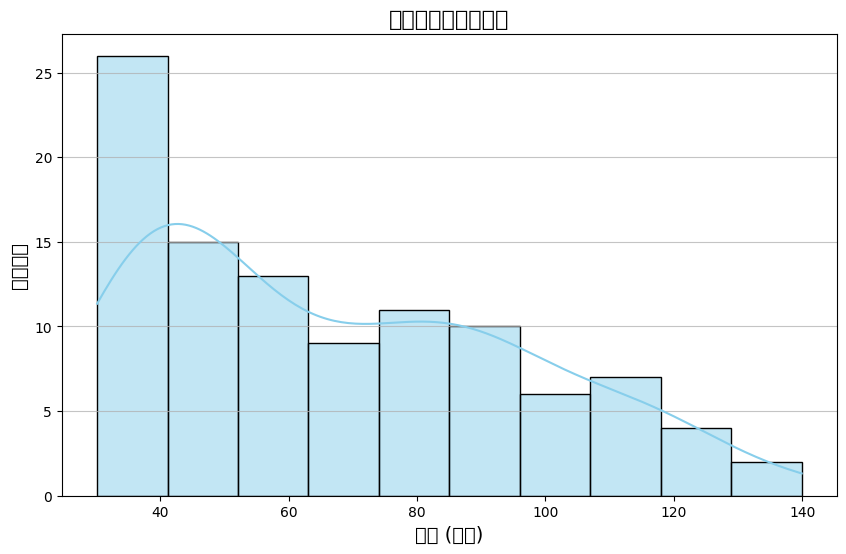

In [91]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


duration_minutes = []
for anno in tqdm(annos):
    # print(anno)
    duration_minutes.append(anno['video_info']['duration_minutes'])

# --- 绘制直方图 ---

plt.figure(figsize=(10, 6)) # 设置图的大小

# 使用 seaborn 的 histplot 绘制直方图
# kde=True 会绘制核密度估计（KDE）曲线，展示数据分布的平滑近似
# bins 可以控制直方图的条形数量或具体的边界
sns.histplot(duration_minutes, bins=10, kde=True, color='skyblue')

plt.title('视频时长分布直方图', fontsize=16) # 设置图表标题
plt.xlabel('时长 (分钟)', fontsize=14) # 设置 X 轴标签
plt.ylabel('视频数量', fontsize=14) # 设置 Y 轴标签
plt.grid(axis='y', alpha=0.75) # 添加 Y 轴网格线

plt.show() # 显示图表

## 专攻检索 decoding 的效果

In [ ]:
import json
import os

result = '/share/minghao/VideoProjects/lmm-eval-sparse/logs/LVBench/media/lvbench_selfmedia-sparse-600-ds4_prev11_rollcache_notrain_top8/0525_0210_videoxl_videoxl_model_args_32bfd6/lvbench_selfmedia.json'

prefix = result.split('/')[-1].split('_samples')[0]

if 'jsonl' in result:
    with open(result, 'r') as file:
        datas = [json.loads(line) for line in file]
else:
    with open(result, 'r') as file:
        datas = json.load(file)
        datas = datas['logs']

logs = datas

global_correct = 0
total = 0

correct_by_task = {}
total_by_task = {}

records_pred_answer = []
for every_res in logs:
    mlvu_percetion_score = every_res['lvbench_mc_accuracy']
    task_type = every_res['doc']['question_type'][0]


    pred_answer = mlvu_percetion_score['pred_answer']

    answer = mlvu_percetion_score['gt_answer']

    if pred_answer == answer:
        if task_type not in correct_by_task:
            correct_by_task[task_type] = 1
        else:
            correct_by_task[task_type] += 1

    if task_type not in total_by_task:
        total_by_task[task_type] = 1
    else:
        total_by_task[task_type] += 1

    if answer == pred_answer:
        global_correct += 1

    total = total + 1

new_result_to_result = {}

for items in correct_by_task.items():
    task_type = items[0]
    correct = items[1]
    accuracy = correct_by_task[task_type]/total_by_task[task_type]*100
    print(f'{task_type} {correct_by_task[task_type]} {total_by_task[task_type]} {accuracy:.2f}')

    new_result_to_result[task_type] = {
        'total': total_by_task[task_type],
        'correct': correct,
        'accuracy': accuracy
    }    


print(f'global_correct: {global_correct}')
print(f'total: {total}')
print(f'ACC: {global_correct/total*100:.2f}')

new_result_to_result['global'] = {
    'total': total,
    'correct': global_correct,
    'accuracy': global_correct/total*100
}

task_types = list(new_result_to_result.keys())
save_name = prefix + '_' + 'results_each_dataset'
for tt in task_types:
    if tt == 'global':
        continue
    save_name = save_name + '_' + tt
save_name = save_name + '.json'

save_dir = os.path.dirname(result)
save_path = os.path.join(save_dir, save_name)

with open(save_path, 'w') as file:
    json.dump(new_result_to_result, file, indent=4)

entity recognition 46 105 43.81
key information retrieval 25 42 59.52
summarization 3 15 20.00
event understanding 51 103 49.51
reasoning 25 40 62.50
temporal grounding 3 12 25.00
global_correct: 153
total: 317
ACC: 48.26


In [18]:
import json

results_each_dataset = []

results_each_dataset = None
if results_each_dataset is None:
    import glob
    directory = "/share/minghao/VideoProjects/lmm-eval-sparse/logs/LVBench/doc"
    # 递归搜索所有子目录，匹配包含 'qin' 的 .jsonl 文件
    results_each_dataset = glob.glob(f"{directory}/**/*results_each_dataset*.json", recursive=True)

# results_each_dataset = [tmp for tmp in results_each_dataset if "notrain" not in tmp]
# results_each_dataset = [tmp for tmp in results_each_dataset if "stage4" not in tmp]

columns = ['event understanding', 'entity recognition', 'reasoning', 'summarization', 'temporal grounding', 'key information retrieval', 'global']


markdown_table = "| Model Name | " + " | ".join(columns) + " |\n"
markdown_table += "|" + "------------|" + "-------|" * len(columns) + "\n"

max_performance_record = {}
for result_path in results_each_dataset:
    # print(result_path)
    with open(result_path, 'r') as f:
        data = json.load(f)

    model_name = result_path.split('/')[-3]
    # 提取列名和准确率
    accuracies = []
    for col in columns:
        accuracies.extend([f"{data[col]['accuracy']:.2f}" ])
        if (col not in max_performance_record or data[col]['accuracy'] > max_performance_record[col]['accuracy']) and col != 'global':
            max_performance_record[col] = data[col]
            max_performance_record[col]['source'] = model_name

    # 构造 Markdown 表格
    markdown_table += f"|  {model_name}  | " + " | ".join(accuracies) + " |\n"

# 打印结果
print(markdown_table)
print()
# print(max_performance_record)
print()

correct = 0
total = 0

avg_acc = 0

for key, val in max_performance_record.items():
    print(f"{key}: correct {val['correct']}, total {val['total']}, acc {val['accuracy']:.2f}, source {val['source']}")
    correct = correct + val['correct']
    total = total + val['total']
    avg_acc = avg_acc + val['accuracy']

print(f"\nBest Performance: {correct / total*100:.2f}")
# print(f"Avg Acc: {avg_acc / len(max_performance_record):.2f}")

| Model Name | event understanding | entity recognition | reasoning | summarization | temporal grounding | key information retrieval | global |
|------------|-------|-------|-------|-------|-------|-------|-------|
|  lvbench_documentary-sparse-600-ds4_prev11_rollcache_notrain_top5  | 58.93 | 49.43 | 54.17 | 60.00 | 66.67 | 36.36 | 51.78 |
|  lvbench_documentary-sparse-600-ds4_prev11_rollcache_notrain_top4  | 57.14 | 50.57 | 54.17 | 60.00 | 66.67 | 40.91 | 52.28 |
|  lvbench_documentary-sparse-600-ds4_prev11_rollcache_notrain_top6  | 58.93 | 49.43 | 54.17 | 60.00 | 66.67 | 36.36 | 51.78 |
|  lvbench_documentary-sparse-600-ds4_prev11_rollcache_notrain_top8  | 53.57 | 50.57 | 54.17 | 60.00 | 66.67 | 31.82 | 50.25 |
|  lvbench_documentary-sparse-600-ds4_prev11_rollcache_notrain_top7  | 55.36 | 49.43 | 58.33 | 60.00 | 66.67 | 31.82 | 50.76 |



event understanding: correct 33, total 56, acc 58.93, source lvbench_documentary-sparse-600-ds4_prev11_rollcache_notrain_top5
entity recognition: c

In [43]:
results_dict = {'lvbench_live': {'total': 262, 'correct': 124, 'acc':46.18}, # 122, 124
 'lvbench_tv': {'total': 250, 'correct': 116, 'acc':48.40},
 'lvbench_documentary': {'total': 197, 'correct': 99, 'acc':53.30},
 'lvbench_selfmedia': {'total': 317, 'correct': 148, 'acc':50.79},
 'lvbench_cartoon': {'total': 283, 'correct': 125, 'acc':45.58}, #124, 125
 'lvbench_sport': {'total': 240, 'correct': 116, 'acc':48.41}} #114, 116
 
t = 0
c = 0
acc = 0
for v_type, info in results_dict.items():
    t += info['total']
    c += info['correct']
    acc += info['acc'] * info['total']
print(f'total: {t}, correct: {c},  acc: {c/t*100:.2f}')
print(f'acc: {acc/t:.2f}')

total: 1549, correct: 728,  acc: 47.00
acc: 48.62
